<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# Week 8 - NLP, N-grams and FastText

As you have seen in the lectures, NLP has a wide range of techniques and applications of such techniques. We will give you an introduction to some of these techniques, and today you will get hands-on experience with them. In today's exercise, we will look at the following topics:

1. How do we represent text in a vectorized way that encodes context? (One answer here is N-grams, and those we will look at).
2. How do we create and sample from an N-gram language model - and how does the size of the grams affect the generated text?
3. How do we use a pre-existing language model (FastText), to classify text messages as spam?

The data we will be using later today is a dataset consisting of "spam or ham" text messages. The dataset consists of a number of text messages, some of which are spam and some of which are so-called "ham". We will use FastText to classify mails as spam or ham. For now, we will be looking at some different texts, to see how we can use N-grams to generate text, and how we can create N-gram language models from a text corpus.

---

**At the end of this week, you should be able to:**

- Know what N-grams mean
- Know how word-wise and character-wise N-grams can be constructed
- Know how to model next-word probabilities given a context
- Know how to model next-n-gram probabilities given a context
- Know roughly how Fasttext uses n-grams and character-grams

**Optional:**

- Know how to implement your own fasttext model
- Know how to fiddle around with parameters in the fasttext library


---

## **N-grams and word probability models:**

Recall we want to use the N-grams for probabilistic word modelling tasks, for example, next word predictions given some sequence of words which we can express the following way:

$$
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1})
$$
The problem is that estimating such probabilities for very long sequences is computationally and memory-wise VERY expensive. So as a solution we sometimes use N-grams. In N-grams, the assumption is that we can model these conditional dependencies with shorter sequences of words, i.e.:

$$
\begin{split}
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n) \quad \text{(Unigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n| w_{n-1}) \quad \text{(Bigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n|w_{n-2}, w_{n-1}) \quad \text{(Trigram)}\\
\end{split}
$$

Which we then compute as:

$$
P(w_n|w_{n-2}, w_{n-1}) = \frac{\text{Count}(w_{n-2}, w_{n-1}, w_n)}{\text{Count}(w_{n-2}, w_{n-1})}
$$

The language model that we create is based on some text corpus from which we obtain the count measures.


**Fasttext (briefly):**

Fasttext is a model created by Meta (back when they were still facebook). Basically, it is a [CBoW or SkipGram model](https://fasttext.cc/docs/en/unsupervised-tutorial.html#Advanced%20readers:%20skipgram%20versus%20cbow), which uses **both character and word n-grams**.

CBoWs and Skipgrams are 'nothing special', they're quite ubiquitous, especially around the time of fasttext, what set it apart was a lot of clever software tricks, as well as its use of n-grams. This is arguably what you should focus on learning about it, if anything.

</span>

In [1]:
import re
import os
import torch

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 1: N-grams and word probabilites

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 1: Text-loading


The texts we will be experimenting with N-grams on are the two famous books Pride & Prejudice by Jane Austen and The Origin of Species by Charles Darwin. The two books have been obtained in a raw text format from https://www.gutenberg.org/, i.e. Project Gutenberg which concerns itself with the collection of Open Access e-books.

A big part of working with text documents is unfortunately having to preprocess the documents. Preprocessing of these, can have a large impact on the eventual performance of language models, such as N-gram models. We have included the text-preprocessing steps in the cell below. In the output cell you will notice that the first chapter of pride and prejudice is printed out. It is then preprocessed using the `preprocess_text` function and printed out again.

#### **💻 1.1. Implement the `preprocess_text` function according to the following description:**

1. Remove empty characters using `.strip()`
2. Make all text lowercase
3. Remove all special characters by using the regex pattern.
   - *HINT: Here you can make use of Python's [re.sub](https://www.geeksforgeeks.org/python/re-sub-python-regex/) function. Basically, we want to **keep** all characters that are not alphanumeric, I.E. lower- and uppercase A-Z, 0-9.*
4. Split the text by newlines so we can remove chapter headlines
   -  *HINT: `\n` is the character used for newlines*
5. Remove chapter headlines
6. Join the document again, which was previously split by newlines
7. Replace `\n` with whitespace and double-whitespaces with single whitespaces

#### **1.2. Even if implemented correctly, this preprocessing is not perfect. Do you notice any issues in the text? Show examples of words that will may be problematic:**


*HINT: What happens to *good-humoured*? What happens to *three-and-twenty*? What happens to *Mr.* and *Mrs.*, and how will this later be handled when we split the sentences?*


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

If two words are separated by a character that we remove they will become a single word. And creating sentences through the use of full-stops means "Mr. Harvey" will become two sentences "Mr" and "Harvey".

You can look at the cell below `preprocess_text`, where we show some problematic examples

</span>

#### **💻 1.3 Apply the preprocessing to the texts for today: "pride_and_prejudice.txt" and the "origin_of_species.txt"**



</span>

In [2]:
def preprocess_text(text):
    """TODO: MISSING DOCSTRING

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    text = text.strip()
    text = text.lower() #Lowercase everything in text file.
    text = re.sub(r"[^a-zA-Z0-9.?! \n]+", "", text) #Remove unwanted special characters.
    text = text.split("\n") #Split text by lines.
    text = [line.strip() for line in text if line.find("chapter") == -1] #Remove chapter headlines.
    text = "\n".join(text) #Recreate full document again
    text = text.replace("\n", " ").replace("  ", " ") #Remove end lines and remove double spacing.
    return text

In [3]:
print(preprocess_text("good-humoured"))
print(preprocess_text("Mr."))
print(preprocess_text("I am, but"))

goodhumoured
mr.
i am but


In [4]:
# Apply preprocessing of Pride and Prejudice and Origin of species here

with open("data/pride_and_prejudice.txt", "r", encoding="utf-8") as file:
    pride_n_pred = file.read()
    pride_n_pred_preproc = preprocess_text(pride_n_pred)

with open("data/origin_of_species.txt", "r", encoding="utf-8") as file:
    orig_of_spec = file.read()
    orig_of_spec_preproc = preprocess_text(orig_of_spec)

print(f"Pride and prejudice preprocessed: {pride_n_pred_preproc}")
print(f"Origin of species preprocessed: {orig_of_spec_preproc}")

Pride and prejudice preprocessed:  it is a truth universally acknowledged that a single man in possession of a good fortune must be in want of a wife. however little known the feelings or views of such a man may be on his first entering a neighbourhood this truth is so well fixed in the minds of the surrounding families that he is considered as the rightful property of some one or other of their daughters. my dear mr. bennet said his lady to him one day have you heard that netherfield park is let at last? mr. bennet replied that he had not. but it is returned she for mrs. long has just been here and she told me all about it. mr. bennet made no answer. do not you want to know who has taken it? cried his wife impatiently. you want to tell me and i have no objection to hearing it. this was invitation enough. why my dear you must know mrs. long says that netherfield is taken by a young man of large fortune from the north of england that he came down on monday in a chaise and four to see th

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 2 - Creating N-grams

Now that we've preprocessed our text, we can start to use it to create N-grams, and to calculate next-word probabilities.

#### **2.1 How do can N-grams encode the context of a text? This is especailly when compared to methods such as just vectorizing single words?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

N-grams take the ordering of the words into consideration. So the vector-representation of *"not bad"* and *"bad not"* would not necessarily be the same

</span>

#### **💻 2.2 Implement the below function `tokenize_and_pad`. It should:**

1. Split the corpus into sentences *Using a full stop as the delimiter*
2. Calculate the length of the padding needed
    - Think about how many words are needed to create the first N-gram **of length N**? *Hint: The first actual word is included*
3. Create the padding for the front and end using for example `" ".join(list_of_start_chars)`
    - In Python you can create a list of length pad_len using `[el] * pad_len`
4. Pad each corpus sentence ensuring that there is a space between the padding and sentence
    - Use the .strip() method on each sentence to remove empty characters
Split the padded sentences into words and return a list of lists containing the split sentences


#### **💻 2.3 Complete the `create_n_grams` function to create N-grams with length of the parameter `N` based on the tokinzed sentences. You can use the following approach:**

1. Create and empty list for the n_grams
2. Loop across all the tokenized sentences
3. Now loop across the range of applicable starting indexes for the given sentence
    - If N = 2, what's the length of the sentences list and how many N_grams can we create? Generalise this.
4. Create the current n_gram by using `" ".join`
5. Return the n_grams list


#### **2.4: Test the implementations of both above functions by running the cell two steps below. Does it produce the expected output? Could anything be improved?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>




In [5]:
def tokenize_and_pad(corpus, N):
    """
    Split corpus into a list of lists so each outer list is a sentence in the corpus
    And each inner list is the words contained in that sentence
    With N <s> tokens added to the front of those sentenes, and N </s> tokens added at the end of each sentence

    Args:
        corpus (str): One long string of the whole corpus to tokenize
        N (int): Length of the N-grams to generate

    Returns:
        list[list[str]]: List of lists of strings as defined in the description
    """
    # Split sentences - this is by full stop
    corpus_sentences = corpus.split(".")

    # If we want to create N-grams of length 3, we need to add 2 padding, since first word + two padding = 3 length N-gram
    pad_len = N - 1

    # Create the padding that we want at the front and end at each sentence - we don't need it in the middle
    pad_front = " ".join(["<s>"] * pad_len)
    pad_end = " ".join(["</s>"] * pad_len)

    # Add the padding to each sentence in the corpus
    padded_corpus_sentences = [pad_front + " " + sentence.strip() + " " + pad_end for sentence in corpus_sentences]

    # Tokenize the sentences, so each word is a token I.E an item in a list
    tokenized_corpus_sentences = [sentence.split(" ") for sentence in padded_corpus_sentences]
    return tokenized_corpus_sentences


def create_n_grams(tokenized_sentences, N):
    """Take a list of lists of tokenized sentences and split into N-grams and return a list of N-grams.

    Args:
        tokenized_sentences (list[list[str]]): List of lists, each item in the outer list is a sentence, each item in the inner lists is...
        ... either a word or a padding token of that sentence.
        N (int): Length of the N-grams to generate

    Returns:
        list[str]: list strings where each list item is an N-gram, either with or without padding.
    """
    n_grams = []
    for sentence in tokenized_sentences:
        for i in range(len(sentence) - N + 1):
            # Create each n-gram by joining N consecutive words
            n_gram = " ".join(sentence[i:i + N])
            n_grams.append(n_gram)
    return n_grams

def create_n_grams_from_corpus(corpus, N):
    """Convenience function to call instead of two above functions one after the other

    Args:
        corpus (str): String with whole corpus to create N-grams from
        N (int): Length of the N-grams to generate
    Returns:
        list[str]: List of all N-grams. <s> or </s> tokens added to ensure all are of length N
    """

    return create_n_grams(tokenize_and_pad(corpus, N), N)

In [6]:
# chosen_text = orig_of_spec_preproc
chosen_text = pride_n_pred_preproc

# Tokenize and pad the text
N = 3
chosen_text_tokenize = tokenize_and_pad(chosen_text, N=N)
print(chosen_text_tokenize[:5])

# Create n-grams
chosen_text_n_grams = create_n_grams(chosen_text_tokenize, N=N)
print(chosen_text_n_grams[:20])

[['<s>', '<s>', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '</s>', '</s>'], ['<s>', '<s>', 'however', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood', 'this', 'truth', 'is', 'so', 'well', 'fixed', 'in', 'the', 'minds', 'of', 'the', 'surrounding', 'families', 'that', 'he', 'is', 'considered', 'as', 'the', 'rightful', 'property', 'of', 'some', 'one', 'or', 'other', 'of', 'their', 'daughters', '</s>', '</s>'], ['<s>', '<s>', 'my', 'dear', 'mr', '</s>', '</s>'], ['<s>', '<s>', 'bennet', 'said', 'his', 'lady', 'to', 'him', 'one', 'day', 'have', 'you', 'heard', 'that', 'netherfield', 'park', 'is', 'let', 'at', 'last?', 'mr', '</s>', '</s>'], ['<s>', '<s>', 'bennet', 'replied', 'that', 'he', 'had', 'not', '</s>', '</s>']]
['<s> <s> it', '<s> it is', 'it is 

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 - Calculating word probabilites

Now that we have created our N-grams, we can use our texts as a training set to naively calculate next-word probabilities based solely on examples.


#### 💻 3.1 Read the function `n_grams_to_prob_map` which takes a list of n_grams as returned by the function above and create a dictionary which maps the probabilities of words occurring after a given context. In particular, try to find out how it actually calculates the probability of a word or N-gram appearing in a certain context

 <!-- **💻 3.1 Implement the function `n_grams_to_prob_map` which takes a list of n_grams as returned by the function above and create a dictionary which maps the probabilities of words occurring after a given context. You can use the following approach:** -->

<!-- 1. If you are unfamiliar with the defaultdict class in Python, read this article before you start this task https://www.geeksforgeeks.org/defaultdict-in-python/
2. If you are unfamiliar with the lambda keyword in Python, read this article before you start this task https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/?ref=header_outind
3. Create a default dict, name it `contexts`, with a default value that is a default dict whose default value is 0
    - In essence: defaultdict(defaultdict(0))
    - This will be used to count how often each target word occurs after a certain context
4. Loop through every n-gram and split it
5. Create the context by using `" ".join` on all but the last token in the n-gram. The last token is the target
6. Increment (means adding 1 to a value) the counter for the target value for the given context
7. Create a new dictionary `cond_prob`
8. Loop across the keys of `contexts`
9. Create a list of each target in the current context by wrapping the .keys() call in a list()
10. Count the number of occurrences of each target in the current context and put them in a numpy array
11. Calculate the probabilities of each target by normalising the occurrence count 
    - Ensure it sums to 1
12.  Assign a tuple of the targets and their probabilities to the entry in the `cond_prob` function
    - The order of the tuple is important for later, so (context_targets, targets_probs) -->

#### **3.2 Inspect the plot of the targets does the "top contender" make sense?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It's a stop word *"a"* which is very common. Though, we can't really gain much insight from it, except for perhaps generating our own texts.

</span>


#### **3.3 Change the chosen_text to be the *Origin of Species* without changing anything else. Look at the plot now, why do you think we started with *Pride and Prejudice?***

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The 60'th phrase in the Origin of Species is *"effects <\/s>"*, since it is a "phrase" with a single bit of padding, the only possibility is for the last value is another "<\/s>"... not really that interesting...

This is assuming you go with $N = 3$, still of course, if you don't use this, your result may vary.

</span>


#### **3.4. Vary the N-gram size, `N`. Inspect the first 20 N-grams created now. What might change with the conditional probabilities, and what problems might arise from this?.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

One potential issue, is that as the number of N-grams increases, the 'uniqueness' of each N-gram decreases. I.E it is harder to find a specific phrase of length 4, than it is to find a specfic phrase of length 2, which is still even harder than finding a single word.

If we increase this too much, we may end up in a situation where we cannot make any assumptions about the next "word", since each word is an impossibly long N-gram...

</span>

In [7]:
def n_grams_to_prob_map(n_grams):
    """Given a text of n-grams, create a mapping so each n-gram can be considered a context with different targets that appear with a given probability

    NOTE: If only unigrams (N=1) added. No context is present for any single word, thus no word conditional probabilities can be inferred

    Args:
        list[str]: List of all N-grams. <s> or </s> tokens added to ensure all are of length N

    Returns:
        dict[str: tuple(list[str], np.ndarray[float])]: dict where the keys are contexts, the values are tuples of targets and probabilities...
        ... where the targets[i] appears with probabilities[i] probability in the given context
    """
    
    # Generally, using lambdas is seen as bad practice by the Python community. We make an exception for default dicts
    defaultdict_function = lambda: defaultdict(lambda: 0)
    
    # Create a sort of nested default dict...
    # ... This is so that each context is initialized as a defaultdict where each word in that context
    # ... starts as probability 0 to be in that context
    contexts = defaultdict(defaultdict_function)

    # Get the size of the N-grams
    N = len(n_grams[0].split(" "))

    for n_gram in n_grams:
        # Split N-grams (which are strings) on whitespace
        n_gram_split = n_gram.split(" ")

        # Get the context as the N-1 preceding words before a given word
        context = " ".join(n_gram_split[:N-1])

        # The target is then the last word after the given context
        target = n_gram_split[N-1]

        # Increment the amount of times we have seen that specific target after that specific context by 1
        contexts[context][target] += 1

    cond_prob = {}
    for context in contexts.keys():
        # Get all words that appear AFTER the current context
        context_targets = list(contexts[context].keys())

        # targets_count is an array of how many times we have seen every target that appears after given context
        targets_count = np.array([contexts[context][target] for target in context_targets])

        # Sum how many appearances there are in total
        context_sum = np.sum(targets_count)

        # Get the probability by dividing each count by the total number of appearances
        targets_probs = targets_count / context_sum
        cond_prob[context] = (context_targets, targets_probs)
    return cond_prob

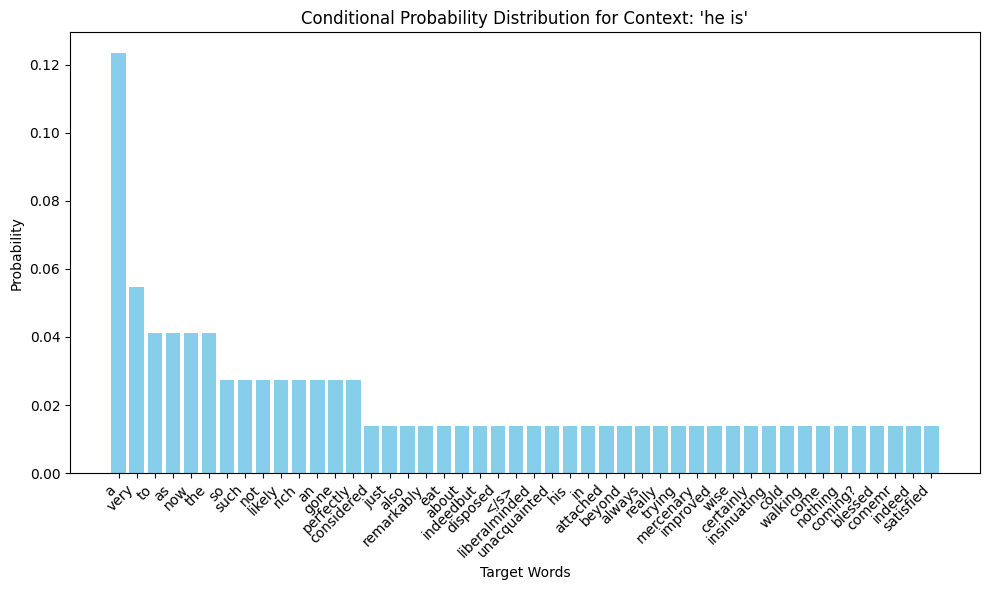

In [8]:
chosen_text_cond_prob = n_grams_to_prob_map(chosen_text_n_grams)

chosen_n_gram = 60 # The phrase "he is considered" for pride and prejudice
context_test = chosen_text_n_grams[chosen_n_gram].split(" ")[:-1] # Get the last word in this phrase
context_test = " ".join(context_test)

# Index out probabilities with this given context
targets, probs = chosen_text_cond_prob[context_test]

# Sort the targets and probabilities for convenience
sorted_targets, sorted_probs = zip(*sorted(zip(targets, probs), key=lambda x: x[1], reverse=True))

# Plot the targets
plt.figure(figsize=(10, 6))
plt.bar(sorted_targets, sorted_probs, color='skyblue')
plt.xlabel("Target Words")
plt.ylabel("Probability")
plt.title(f"Conditional Probability Distribution for Context: '{context_test}'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout for readability
plt.show()

In [9]:
# 3.4: Inspecting first 20 N-grams
N=4
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
print(orig_of_spec_n_grams[:20])

['<s> <s> <s> causes', '<s> <s> causes of', '<s> causes of variability', 'causes of variability </s>', 'of variability </s> </s>', 'variability </s> </s> </s>', '<s> <s> <s> effects', '<s> <s> effects of', '<s> effects of habit', 'effects of habit </s>', 'of habit </s> </s>', 'habit </s> </s> </s>', '<s> <s> <s> correlation', '<s> <s> correlation of', '<s> correlation of growth', 'correlation of growth </s>', 'of growth </s> </s>', 'growth </s> </s> </s>', '<s> <s> <s> inheritance', '<s> <s> inheritance </s>']


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4 - Generating text with conditional probabilities

In the previous exercise we saw how to tokenize a corpus such that it is ready to be split into n-grams. We then saw how to make n-grams and create a conditional probability based on these.

The question now is, how can we generate a text using this conditional probability. A way of doing this is to sample from a conditional probability distribution based on our obtained N-grams. In essence, we can give a seed to our conditional probability (also called a context), and then we need to generate a word from our conditional probability by sampling from it.

In the code below we will define a function that allows us to generate a sentence based on a provided conditional distribution. In the cell we create such a conditional distribution and generate 5 sentences using the same text seed. 

#### **4.1. 💻 Implement the `generate_text` function. Given a seed start text and some context probabilities (as created by the previous exercises), it should generate additional text.**

You can use  following as help to implement it:

1. Create a variable which will be the output string and assign the text_seed to it
2. Split the text_seed into words and check its length, it should be N-1
    - If the text seed is too short append the start character to it
    - If the text seed is too long change it to the last N-1 words
3. Create a variable that holds the current context (text_seed right now)
4. Loop across the number of words we wish to generate
   - If the current context is not in the `cond_prob` dictionary, return the generated sentence
   - If it is, sample a target word from the context according to its probability distribution and update the context for the next iteration

#### **4.2. Answer the following questions about the text generation you have just implemented:**

1. Why is it that even though we use the same text seed, the generated sentences changes?
2. What happens as you increase the N-gram size as shown in the cell below? Does this makes sense - and if so, why?
3. Is it more optimal to have smaller or larger N-gram size? Try to experiment with generated sentences as N goes from 2->7.
4. What would it mean to set the N-gram size to one? What would you expect the generated text to look like?

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1. Because we are sampling from the distribution and not simply using the most probable word.
2. There are fewer and fewer examples of each context in the text which leads to less text being generated.
3. The higher the n-gram size the fewer examples of each n-gram there is.
4. There is not target for any context so no text is generated.


</span>


</span>

In [10]:
def generate_text(cond_prob, text_seed, N, num_words=25):
    """TODO: MISSING DOCSTRING!

    Args:
        cond_prob (_type_): _description_
        text_seed (_type_): _description_
        N (_type_): _description_
        num_words (int, optional): _description_. Defaults to 25.

    Returns:
        _type_: _description_
    """
    
    # Set the initial sentence to the seed text
    generated_sentence = text_seed
    text_seed_words = text_seed.split(" ")

    # If the length of the seeded text is less than the length of n-grams chosen, we must add padding to the start
    if len(text_seed_words) < N-1:
        pad_len = (N-1) - len(text_seed_words)
        pad_list = ["<s>"] * pad_len
        text_seed = " ".join(pad_list+text_seed_words)
    
    # Else, if it is longer, we join the first few words, and only use the last words
    elif len(text_seed_words) > N-1:
        text_seed = " ".join(text_seed_words[-N+1:])
    
    context = text_seed
    for i in range(num_words):
        if context not in cond_prob.keys():
            return generated_sentence

        else:
            generated_sentence += " " + np.random.choice(cond_prob[context][0], 1, p=cond_prob[context][1])[0]
            context = " ".join(generated_sentence.split(" ")[-N+1:])
    return generated_sentence

In [11]:
N=2 # N-grams of length 2
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)

text_seed = "he is a"
for i in tqdm(range(5)):
    generated_text = generate_text(cond_prob=orig_of_spec_cond_prob, text_seed=text_seed, N=N) 
    print(generated_text + '\n')

  0%|          | 0/5 [00:00<?, ?it/s]

he is a space prevents my theory of the puppies from some degree </s>

he is a general shape which when the diagram to show how useful to return </s>

he is a new varieties our mountainsummits having been more easily suck the descendants proceeding from the trumpeter and i further admits that it </s>

he is a lion the plant cannot doubt was included in lesser degree whenever it has come to behold the term several facts with special use for the

he is a new zealand but the checks </s>



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 5 - Varying N-gram length for text generation

It can be interesting to examine how the text generation can vary given with the length of our N-grams. Here, we will do so.

#### **5.1. 💻 Write code to create N-grams and conditional probability maps using Pride and Prejudice as the corpus for sizes of N-grams varying from $N = 1,2, \dots,5$. Answer the following questions:**

1. What happens with the total number of contexts as $N$ increases? Why does it increase like this?
2. Why is the number of contexts in the case of $N=1$ empty? (It should be if you implemented `n_grams_to_prob_map` and `create_n_grams` correctly!)

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1. It increases, seemingly logarithmically. In normal combinatorics, we would expect an exponential growth, as we have $W$ words to choose from, and $N$ words following an initial word, leading to $W^N$ combinations. However, many word combinations just don't exist. You wouldn't ever say "Thus thus thus thus thus", so even if $N=5$, and it is possible to contain such an N-gram, you woudln't ever see it in the corpus
2. Because our functions use n-grams to create the conditional probabilities. The first word in an N-gram works as context for the remaining words. When we only have unigrams, the first word has no context.

</span>


</span>

In [12]:
for N in tqdm(range(1, 5+1)):
    orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
    orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
    orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)

    num_contexts = len(orig_of_spec_cond_prob.keys())

    print(f"Maximum N-gram length: {N}: Number of contexts: {num_contexts}")

  0%|          | 0/5 [00:00<?, ?it/s]

Maximum N-gram length: 1: Number of contexts: 1
Maximum N-gram length: 2: Number of contexts: 7955
Maximum N-gram length: 3: Number of contexts: 61237
Maximum N-gram length: 4: Number of contexts: 116773
Maximum N-gram length: 5: Number of contexts: 143185


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 2: Fasttext for 'Ham og Spam'

In the following exercises we will be looking at classifying text messages as "Ham" or "Spam" by using Fasttext models. 

- First, we will format our data to comply with the Fasttext library,
- Then, we will implement our own Pytorch model to run on the data
- Finally, we will use the much faster Fasttext library to achieve the same results.

**There isn't much coding in this section (we removed a lot of the exercises), since it would probably take too long for you to implement. If you want a version with no coding answers, you can open the extra file "ex_week_8_more_coding.ipynb" instead**

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6 - Preparing spam or ham data

In the following cells we use the pandas library to load our text delimited file which has the labels in the first column and the text messages in the second. Fasttext expects a file where each line has the signature  `__label__{label} text` (where `__label__` is a token, i.e. something the FastText library reads as a keyword).

#### **💻 6.1 Create a function that given a dataframe containing a column of texts and a column of labels, creates a .txt file where each line starts with `__label__x y` where `x` is the label and `y` is the text.**

You can use the following as a guide to implement it

1. Iterate across the labels and text and write each line to a string in the correct format
2. Use a `with open(path_to_doc)` clause to write the text to a document
3. Include a print statement tha prints the distribution of labels in the test which is only executed if `verbose=True`



#### **💻 6.2 Use the `pandas.read_csv` function to read the `SMS_train.txt` file. Answer the following questions, either by Google or inspecting the dataset:**

- How many text messages are in the training set?
- What's the distribution of labels and how will that impact our training of a classifier? 

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1. 4458 Text messages total
2. There is $\approx 86\%$ ham in the dataset, so most any classifier we train will be 'overtuned' to detecting ham, but this might also be good if the distribution reflects real life. Otherwise, it can be a significant issue that might require our attention!

</span>


In [13]:
def create_fasttext_format_txt(data_frame, path_to_doc, v=True):
    """TODO: MISSING DOCSTRING!

    Args:
        data_frame (pd.DataFrame): Data frame with train- or test-data. 
            feature and label column should be named "1" and "0" respectively
        path_to_doc (str): Where to write the output to
        v (bool, optional): Whether to output additional information about dataset. Defaults to True.

    Returns:
        texts (list[str]): list of input texts to the eventual model 
        labels ([list[str]]) list of "ham" or "spam"
    """

    # Get texts and labels of the data
    texts = list(data_frame['1'])
    labels = list(data_frame['0'])

    # Create a combined txt file which'll hold all our training data
    txt = ""
    
    # Construct FastText formatted string
    for (label, text) in tqdm(zip(labels, texts), total=len(texts)):
        txt += f'__label__{label} {text}\n'
    
    # Write to a txt file
    with open(path_to_doc, mode='w', encoding="utf-8") as f:
        f.write(txt)
    
    # Optional verbose output for label distribution
    if v:
        label_distribution = Counter(labels)
        print("Label Distribution:")
        for label, count in label_distribution.items():
            print(f"{label}: {count} ({count / len(texts) * 100:.2f} %)")
    
    return texts, labels

In [14]:
train_data = pd.read_csv(os.path.join("data", "SMS_train.txt"))
test_data = pd.read_csv('./data/SMS_test.txt', delimiter=',', encoding="utf-8")

train_texts, train_labels = create_fasttext_format_txt(data_frame=train_data, path_to_doc='data/train_data.txt')
test_texts, test_labels = create_fasttext_format_txt(data_frame=test_data, path_to_doc='data/test_data.txt')

  0%|          | 0/4458 [00:00<?, ?it/s]

Label Distribution:
ham: 3865 (86.70 %)
spam: 593 (13.30 %)


  0%|          | 0/1114 [00:00<?, ?it/s]

Label Distribution:
ham: 960 (86.18 %)
spam: 154 (13.82 %)


In [15]:
# Display some mixed exmaples of the train data
display(train_data)

# Display some examples of the test data where the label is "spam"
display(test_data[test_data['0'] == "spam"])

,0,1
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,spam,FreeMsg Hey there darling it's been 3 week's n...
4,ham,As per your request 'Melle Melle (Oru Minnamin...
...,...,...
4453,ham,Ard 6 like dat lor.
4454,spam,REMINDER FROM O2: To get 2.50 pounds free call...
4455,spam,This is the 2nd time we have tried 2 contact u...
4456,ham,"Pity, * was in mood for that. So...any other s..."


,0,1
5,spam,Got what it takes 2 take part in the WRC Rally...
16,spam,Todays Vodafone numbers ending with 4882 are s...
34,spam,Your credits have been topped up for http://ww...
36,spam,U've been selected to stay in 1 of 250 top Bri...
49,spam,Dear U've been invited to XCHAT. This is our f...
...,...,...
1076,spam,Hi. Customer Loyalty Offer:The NEW Nokia6650 M...
1083,spam,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
1096,spam,"Update_Now - Xmas Offer! Latest Motorola, Sony..."
1098,spam,Welcome! Please reply with your AGE and GENDER...


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 7 - Our own fasttext

As you should know by now there are libraries for most things in Python and Fasttext is no Exception. Nonetheless, it is valuable to build the architecture from "scratch" to truly understand what is going on. 
We will use Pytorch, which means we have to create our own dataloader. Since we are working with text data that is embedding through a learned embedding, we will include the embedding part of the network in the Dataloader which is probably not best practice, but done for coding simplicity. 

The embedding module takes as input the indices of each word in a given vocabulary and outputs a vector of the specified dimension as output. This way the gradient can be backpropagated to the embedding by changing the embedding of a corresponding index based on the error. Ask a TA if you want a more in-depth explanation.

Typical hyperparameters for Fasttext
- Embedding dimension: 300
- Batch size: low (1 - you'll help figure this out)
- N_grams: 3-6
- Learning rate: the classic $10^{-3}$ to $10^{-5}$

#### **7.1: Read through the `process_line`, `create_word_grams_from_sentence`, and `create_char_grams_from_sentence` functions, and explain in your own words, what happens in each**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

`process_line`:
- Splits by new line
- Removes '__label__' from each label
- Strips extra whitespaces
- Makes all text lowercase
- Removes all special characters and newlines

`create_word_grams_from_sentence`:
- Creates word-wise n-grams as we know and love them

`create_char_grams_from_sentence`:
- Creates character-wise n-grams from each word passed to it.
- Ensures that words that are shorter than N, do not get 'extra' character-grams added to them.


</span>

💻


**If you do not want to implement this by yourself, simply copy the dataloader from the solution and move on**

The Dataloader has to accomplish the following:
- Loading the txt file of the format created above
- Processing each line of text
    - Use the parts of `preprocess_text` that apply to a single sentence
    - Create the word n-grams or character n-gram of each text using the two functions defined in the cells before the dataloader 
- Build the vocabulary, we must be able to pass the vocabulary from the train loader to the test loader
- Count the distribution of classes
- Create a new `nn.Embedding` module unless one is passed to the dataloader. For testing we need to use the same embedding as we did for training and thus we need to be able to re-use it in the Dataloader.




**1. $\star$ Implement the following functions to be used for processing a line of text in the Fasttext format and creating word and character grams** 


In [16]:
def process_line(line):
    """TODO: MISSING TYPEHINTS
    Given a line assuming the '__label__{label} text' format, split it into the label and text, strip the text, make it lowercase
    remove special characters and remove newlines and double spaces
    Args:
        line (_type_): _description_

    Returns:
        _type_: _description_
    """

    label, text = line.split(maxsplit=1)
    label = label.replace('__label__', '').strip()
    text = text.strip()
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.?! \n]+", "", text)
    text = text.replace("\n", " ").replace("  ", " ")
    return label, text

with open('data/train_data.txt', "r") as f:
    for line in f.readlines()[:10]:
        print(process_line(line))

('ham', 'ok lar... joking wif u oni...')
('spam', 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s')
('ham', 'nah i dont think he goes to usf he lives around here though')
('spam', 'freemsg hey there darling its been 3 weeks now and no word back! id like some fun you up for it still? tb ok! xxx std chgs to send 1.50 to rcv')
('ham', 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers. press 9 to copy your friends callertune')
('spam', 'winner!! as a valued network customer you have been selected to receivea 900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.')
('spam', 'had your mobile 11 months or more? u r entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030')
('ham', 'im gonna be home soon and i dont want to talk about this s

In [17]:
def create_word_grams_from_sentence(sentence, N):
    """TODO: MISSING TYPEHINTS
    Given a sentence and int N, pad the sentence with the start and end character and return a list of word N-grams


    Args:
        sentence (_type_): _description_
        N (_type_): _description_

    Returns:
        _type_: _description_
    """
    pad_len = N - 1
    pad_front = " ".join(["<s>"] * pad_len)
    pad_end = " ".join(["</s>"] * pad_len)
    padded_sentence = pad_front + " " + sentence.strip() + " " + pad_end
    
    sentence_n_grams = []
    sentence_list = padded_sentence.split()
    for i in range(len(padded_sentence.split()) - N + 1):
        n_gram = " ".join(sentence_list[i:i + N])
        sentence_n_grams.append(n_gram)
    
    return sentence_n_grams

example_word_grams = create_word_grams_from_sentence("a simpel simple sentence", 2,)
print(example_word_grams)

['<s> a', 'a simpel', 'simpel simple', 'simple sentence', 'sentence </s>']


In [18]:
def create_char_grams_from_sentence(sentence, min_n, max_n):
    """TODO: MISSING TYPEHINTS
    Given a sentence and the range of character n-grams to produce, return a list of the character grams


    Args:
        sentence (_type_): _description_
        min_n (_type_): _description_
        max_n (_type_): _description_

    Returns:
        _type_: _description_
    """
    assert 0 < min_n
    assert 0 < max_n
    assert min_n <= max_n

    # We will use .extend to append all the elements from a list to another list
    all_char_grams = []
    for n in range(min_n, max_n + 1):
        char_grams = [sentence[i:i + n] for i in range(len(sentence) - n + 1)]
        all_char_grams.extend(char_grams)
    return all_char_grams

example_character_grams = create_char_grams_from_sentence("a simpel simple sentence", 2, 3)
print(example_character_grams)

['a ', ' s', 'si', 'im', 'mp', 'pe', 'el', 'l ', ' s', 'si', 'im', 'mp', 'pl', 'le', 'e ', ' s', 'se', 'en', 'nt', 'te', 'en', 'nc', 'ce', 'a s', ' si', 'sim', 'imp', 'mpe', 'pel', 'el ', 'l s', ' si', 'sim', 'imp', 'mpl', 'ple', 'le ', 'e s', ' se', 'sen', 'ent', 'nte', 'ten', 'enc', 'nce']


In [19]:
def build_vocab(texts):
    """Given a list of texts, count the number of unique words and map each to an index. Add an unknown at the end (for safety)"""
    # Look up the Counter class in python for getting the frequencies of each object
    # This will be used to count the number of unique words
    counter = Counter()
    for text in texts:
        counter.update(text)
    
    # Reserve 0 for padding token
    vocab: dict = {word: idx for idx, (word, _) in enumerate(counter.items())}
    vocab['<UNK>'] = len(vocab)  # Add unknown token
    return vocab
build_vocab([example_word_grams for _ in range(3)])

{'<s> a': 0,
 'a simpel': 1,
 'simpel simple': 2,
 'simple sentence': 3,
 'sentence </s>': 4,
 '<UNK>': 5}

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

Here we implement a subclass of torch.utils.data.Dataset to make loading and processing files much easier.

The real kicker, apart from encapsulation, is that we can implement our own `__getitem__` and `__len__` functions. `__getitem__` is a [Python 'magic method'](https://realpython.com/python-magic-methods/) that is called whenever we iterate over an iterable, for example in a for-loop.

</span>

**2. $\star \star$ Using the description and functions, implement the TextDataset class.**


*The dataset is of a type [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html), usually used when we need a bit more functionality than just yielding items from a list or array*

In [20]:
class TextDataset(Dataset):
    def __init__(self, file_path, embed_dim=300, embedding=None, vocab=None, N_gram=3, minn=0, maxn=0, ):
        self.data = []
        self.labels = set()
        self.class_counts_dict = defaultdict(lambda: 0)
        self.N_gram = N_gram
        self.minn = minn
        self.maxn = maxn
        print(f"Using {'word' if self.minn == 0 or self.maxn == 0 else 'char'} gram model")
        self.process_file(file_path=file_path)
        
        # Build vocabulary and label-to-index mappings
        self.vocab: dict = build_vocab([text for text, label in self.data]) if vocab is None else vocab
        self.vocab_size: int = len(self.vocab)
        self.label_to_idx: dict = {label: idx for idx, label in enumerate(sorted(self.labels)[::-1])}
        self.num_classes: int = len(self.label_to_idx)
        self.embedding = nn.Embedding(self.vocab_size, embed_dim) if embedding is None else embedding
        sorted_labels: list = sorted(self.class_counts_dict.keys(), key=lambda label: self.label_to_idx[label])
        # Sort class_counts based on the sorted order of labels
        self.class_counts: torch.tensor = torch.tensor([self.class_counts_dict[label] for label in sorted_labels])
    
    def process_file(self, file_path):
        # Load and process data
        with open(file_path, 'r') as f:
            for line in f:
                label, text = process_line(line)
                
                if not text.strip():
                    print(line.replace('\n', '') + f" = {text} was skipped")
                    continue
                
                if self.minn == 0 or self.maxn == 0:
                    text = create_word_grams_from_sentence(text, N=self.N_gram)
                else:
                    text = create_char_grams_from_sentence(text, min_n=self.minn, max_n=self.maxn)
                
                self.labels.add(label)
                self.data.append((text, label))
                self.class_counts_dict[label] += 1

    def text_embedded(self, text):
        """ Convert each token to its corresponding index using the vocabulary.get() setting the default to the unknown token.
        Then use the embedding module to embed the indices and take the mean across dim=0."""
        text_indices = torch.tensor([self.vocab.get(word, self.vocab['<UNK>']) for word in text]).int()
        embedded = self.embedding(text_indices).mean(dim=0)
        if torch.isnan(embedded).any():
            print(f"Embedding contains nans!")
            print(text)
        return embedded

    def label_to_tensor(self, label):
        """Convert the label to its corresponding index, cast it to a tensor and call the .long() method on the tensor to ensure the correct dtype"""
        return torch.tensor(self.label_to_idx[label]).long()
    
    def __len__(self):
        """Return the number of datapoints in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Return the text and label at the given index by converting the label to a tensor and the embedding the text."""
        text, label = self.data[idx]
        return self.text_embedded(text), self.label_to_tensor(label)

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

We then implement a single layer that maps from embedding dimension $\rightarrow$ output dimension

</span>


The neural network for Fasttext is a single layer that maps the embedding dimension to the output dimension

**3. Define this simple network and its forward function in the class below**

In [21]:
class TextClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

And we then get a function that given a number appearences for each class can output the inverse class frequency, to give us an idea of the relative proportion of each class in the dataset.

The inverse class frequency for a given class is $ICF(c_1) = \frac{\sum_i^{N}count(c_i)}{count(c_1)}$, where $N$ is the number of classes and $count(x)$ counts the number of occurrences of a given class in the data

</span>

**4. As we saw in the label distribution there is an overweight of the ham class in the data. Create a function which calculates the inverse class frequencies given a tensor of class counts** 

In [22]:
def ICF(class_counts):
    return (torch.sum(class_counts) / class_counts).float()

ICF(torch.tensor((3, 1)))   # Inputting (3, 1) should yield (4/3, 4/1) = (1.3333333, 4.0)

tensor([1.3333, 4.0000])

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 8 - Training our own FastText


Finally, we train the network in the training loop below. Here you can test whether different configurations of batch_size, embedding_dim, and so on, makes a difference.

#### **8.1 We calculate both sensetivity and specificity. Look at their calculations in the code, and explain what they measure**

It calculates the proportion of each class which is classified correctly. In other words, in our case sensitivity is how well spam is detected and specificity how well ham is detected.

#### **8.2 Explain briefly what each of the following parameters means:**

- `N_gram`
- `minn`
- `maxn`
- `lr`
- `embed_dim`
- `batch_size`

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

In order of appearance:

- The number of words to include in word-grams for the model
- The minimum number of characters allowed to be within a character-gram
- The maximum number of characters allowed to be within a character-gram
- The learning rate of the model (duh)
- Effectively, the number of neurons our very shallow neural network uses
- The number of examples for each forward pass during training

</span>

#### **8.3 Look at the confusion matrix, does the result seem good?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Pretty much. It gets most right, but depending on our goal, we might want it to be even more sensetive to either spam or ham.

Imagine if the goal is preventing old people from being scammed, we might want one even better at finding true positives in spam.

If our goal is just an everyday use-case, where we don't really care if people get one or two spam mails (because most people can see them anyways), then just detecting most of them, while having a low false positive count is more important.

</span>



</span>


In [23]:
embed_dim = 300
epochs = 10
batch_size = 16
lr = 0.001
N_gram = 2
minn = 2
maxn = 3
# If we specify BOTH minn and maxn, we use a character gram model
dataset_train = TextDataset('data/train_data.txt', embed_dim=embed_dim, N_gram=N_gram, minn=minn, maxn=maxn)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
class_weights = ICF(dataset_train.class_counts)
print("Class_weights:", class_weights)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using char gram model
__label__ham :-) :-) =   was skipped
Class_weights: tensor([7.5194, 1.1534])
Using cpu


In [24]:
model_save_dir = "models_char"
os.makedirs(model_save_dir, exist_ok=True)

model = TextClassifier(embed_dim=embed_dim, num_classes=dataset_train.num_classes)  # Adjust vocab_size and num_classes as needed
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
metrics = []

for epoch in tqdm(range(epochs)):
    accuracy_train = 0
    all_labels = []
    all_preds = []
    
    for texts_embedded, labels in tqdm(dataloader_train, desc=f"Epoch {epoch}"):
        outputs = model(texts_embedded)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(1)
        accuracy_train += torch.sum(preds == labels)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"{epoch}.pth"))
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}, '
          f'Accuracy: {accuracy_train/len(all_labels):.4f}, '
          f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
    metrics.append([loss.item(), accuracy_train/len(all_labels), sensitivity, specificity])

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 0, Loss: 0.4978, Accuracy: 0.8921, Sensitivity: 0.9524, Specificity: 0.4992


Epoch 1:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2952, Accuracy: 0.9206, Sensitivity: 0.9387, Specificity: 0.8027


Epoch 2:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 2, Loss: 0.3306, Accuracy: 0.9278, Sensitivity: 0.9410, Specificity: 0.8415


Epoch 3:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 3, Loss: 0.3621, Accuracy: 0.9244, Sensitivity: 0.9322, Specificity: 0.8735


Epoch 4:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 4, Loss: 0.4034, Accuracy: 0.9262, Sensitivity: 0.9309, Specificity: 0.8954


Epoch 5:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 5, Loss: 0.2543, Accuracy: 0.9316, Sensitivity: 0.9382, Specificity: 0.8887


Epoch 6:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 6, Loss: 0.3520, Accuracy: 0.9332, Sensitivity: 0.9390, Specificity: 0.8954


Epoch 7:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1006, Accuracy: 0.9307, Sensitivity: 0.9330, Specificity: 0.9157


Epoch 8:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 8, Loss: 0.2548, Accuracy: 0.9359, Sensitivity: 0.9395, Specificity: 0.9123


Epoch 9:   0%|          | 0/279 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1050, Accuracy: 0.9386, Sensitivity: 0.9434, Specificity: 0.9073


The following cell display the latest confusion matrix. Due to the sorting we do (in the solution Dataloader), spam is the positive class and ham the negative:

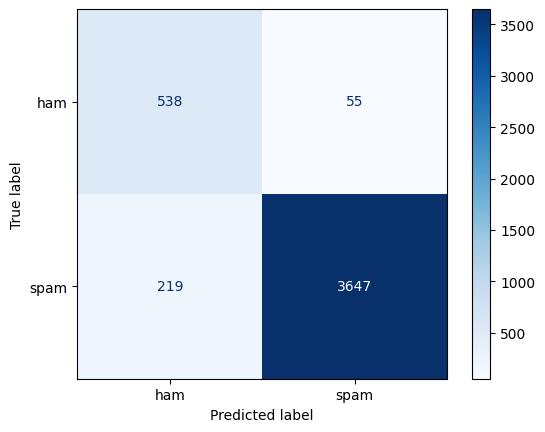

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_train.labels)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()

In [26]:
def plot_metrics(metrics):
    metrics = np.array(metrics)
    metric_names = ['Loss', 'Accuracy', 'Sensitivity', 'Specificity']
    colors = ['red', 'blue', 'green', 'orange']
    
    # Create plots
    plt.figure(figsize=(12, 8))
    
    for i in range(len(metric_names)):
        plt.subplot(2, 2, i + 1)
        plt.plot(range(1, len(metrics[:, i])+1), metrics[:, i], marker='o', label=metric_names[i], color=colors[i])
        plt.title(f'{metric_names[i]} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric_names[i])
        plt.xticks(range(1, len(metrics[:, i]) +1))
        if i == 0:
            plt.ylim(bottom=0)  # Only for Loss, no upper limit
        else:
            plt.ylim(0, 1)  # Set y-limits for accuracy, sensitivity, specificity
        plt.grid()
        plt.legend()
    
    plt.tight_layout()  # Adjust the layout
    plt.show()

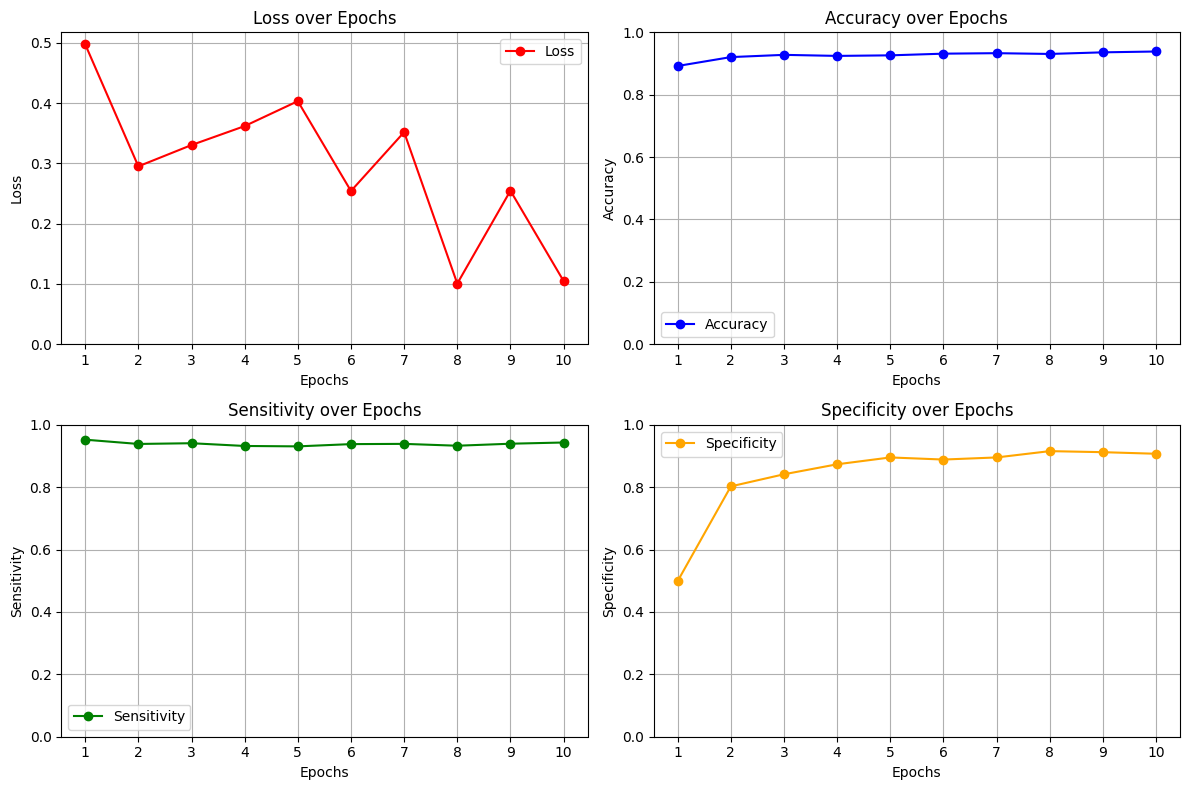

In [27]:
plot_metrics(metrics)

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

During training, we save the network after each epoch, here we just load the network after a number of epochs and run it on the test data.

</span>

In [28]:
epoch_load = 9
model.load_state_dict(torch.load(os.path.join(model_save_dir, f"{epoch_load}.pth"), weights_only=True))

<All keys matched successfully>

**7. Test the network using the loop below:**
- How well does it perform, would you use this for spam detection in a real application?
- Can you improve it?
- The comparison between a word and character model is especially interesting if you consider what the data consists of, why?
The data contains a LOT of spelling mistakes and a word gram model will see two words that are the same but mispelled as two unique words, whereas the character model will have many tokens that end up the same.

Using char gram model
__label__ham :)  =  was skipped
Test loss: 8.2712, Test accuracy: 0.9443 Sensitivity: 0.8831, Specificity: 0.9541


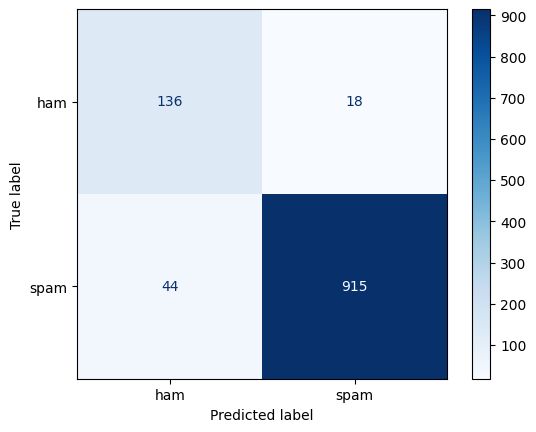

In [29]:
dataset_test = TextDataset('data/test_data.txt', vocab=dataset_train.vocab, embedding=dataset_train.embedding, minn=minn, maxn=maxn)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

accuracy_test = 0
loss_test = 0
all_labels = []
all_preds = []

for texts_embedded, labels in dataloader_test:
    outputs = model(texts_embedded)
    loss_test += criterion(outputs, labels) 
    
    preds = outputs.argmax(1)
    accuracy_test += torch.sum(preds == labels)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate sensitivity and specificity
tp, fn, fp, tn = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {accuracy_test / len(all_labels):.4f} "
      f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_test.labels)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 3: Doing it again with the FastText library.

All that we did above is a good example, but an arguably better implementation of fasttext already exists, the package by the same name.

In the following cells, we will train a model using this package and examine its output.

There are a number of parameters that can be passed to the FastText `train_supervised` function, but we will just concern ourselves with a couples of them.

*The `input` parameter requires a text file as an input containing two columns. The first column must be the classification label and the second must be the text. The format we implemented above*
*The `verbose` parameter just allows us to enable or disable training information. Here we enable it.*


**A lot of the code here, might help you when doing assignment 3, where you also have to work with the fasttext package...**

</span>

In [30]:
# We deferred the import to here so people wouldn't get stuck trying to install it before doing other exercises...
import fasttext 

In [31]:
fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=3)

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  253329 lr:  0.000000 avg.loss:  0.244774 ETA:   0h 0m 0s


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

Here we implement a function to test fasttext given a list of test texts, test labels, and our model. Essentially we just:

1. Loop across the test_texts and labels and use the model to predict the label
    - `model.predict(text)[0][0]` returns a string with the signature `__label__{label}`
2. Keep track of the predictions and labels in two separate lists
3. Use the same function to calculate and display the confusion matrix
4. Calculate the specificity and sensitivity using the same formulas as we did for the other model

</span>

In [32]:
def test_fasttext_model(test_texts, test_labels, fasttext_model, verbose=False):
    predictions = []
    true_labels = []
    
    for text, label in zip(test_texts, test_labels):
        prediction = fasttext_model.predict(text)[0][0].replace('__label__', '')
        predictions.append(prediction)
        true_labels.append(label)
    
    # Calculate confusion matrix
    labels = sorted(set(test_labels))[::-1]  # Ensure consistent label order
    cm = confusion_matrix(true_labels, predictions, labels=labels)


    # Calculate sensitivity and specificity
    tp, fn, fp, tn = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    accuracy = (tp + tn) / np.sum(cm)

    # Print metrics if verbose
    if verbose:
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="Blues")
        plt.grid(False)
        plt.show()
    
        print(f"Sensitivity: {sensitivity:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f'Model accuracy: {accuracy * 100:.2f} %')
    
    return accuracy, cm, sensitivity, specificity

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256241 lr:  0.000000 avg.loss:  0.289796 ETA:   0h 0m 0s


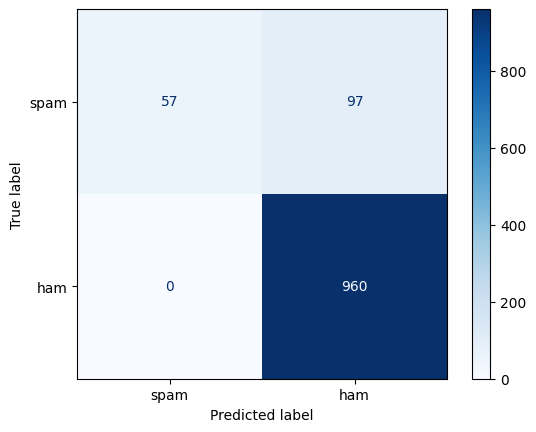

Sensitivity: 0.37
Specificity: 1.00
Model accuracy: 91.29 %


In [33]:
fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=5)
accuracy_word_model, cm_word_model, sens_word_model, spec_word_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_word_model, verbose=True)

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 9 - Varying N-grams


#### **9.1 What happens when you vary the N-gram size when testing? What appears to be the optimnal setting, and why do you think this is the case?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

More or less, the lower the N the better. The dataset contains short sentences and few repeats of the same phrases.

</span>

</span>


In [34]:
# Vary the size of N-grams and check its accuracy across all

metrics = []
for N in range(1, 8):
    fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=N)
    accuracy_word_model, cm_word_model, sens_word_model, spec_word_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_word_model, verbose=False)
    metrics.append((N, accuracy_word_model, sens_word_model, spec_word_model))

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257512 lr:  0.000000 avg.loss:  0.133087 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256256 lr:  0.000000 avg.loss:  0.178425 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257126 lr:  0.000000 avg.loss:  0.228571 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257073 lr:  0.000000 avg.loss:  0.259937 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257101 lr:  0.000000 avg.loss:  0.283523 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256799 lr:  0.000000 avg.loss:  0.310653 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

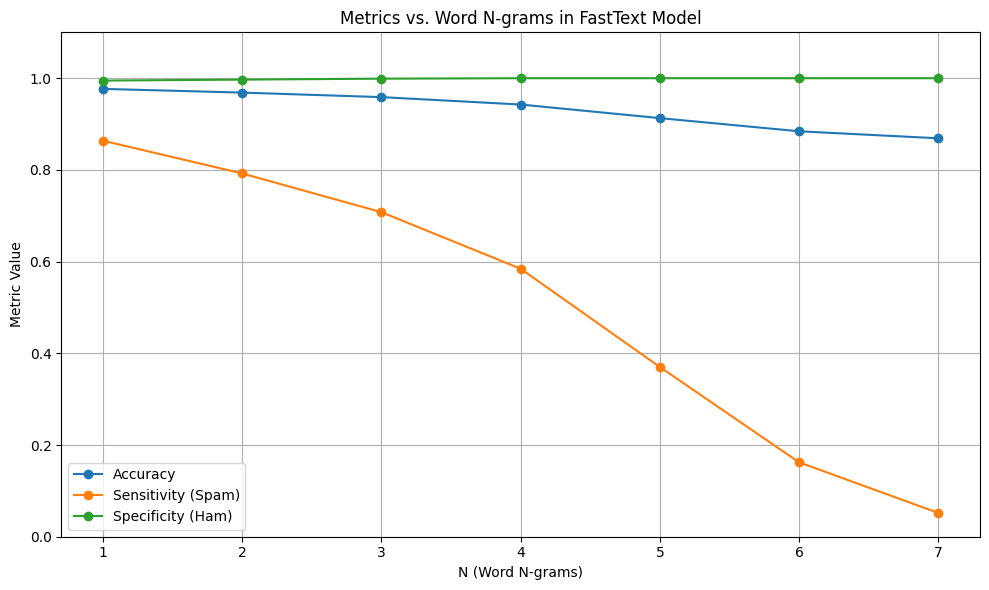

In [35]:
n_values, accuracies, sensitivities, specificities = zip(*metrics)
# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(n_values, accuracies, marker='o', label="Accuracy")
plt.plot(n_values, sensitivities, marker='o', label="Sensitivity (Spam)")
plt.plot(n_values, specificities, marker='o', label="Specificity (Ham)")

# Labeling
plt.title("Metrics vs. Word N-grams in FastText Model")
plt.xlabel("N (Word N-grams)")
plt.ylabel("Metric Value")
plt.ylim(0, 1.1)  # Since metrics are between 0 and 1
plt.xticks(n_values)  # Show only integer N values on the x-axis
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()

plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 10 - Character level model


#### **10.1 In the cell below, we use a fasttext model with character-grams. Does it give better performance? Why do think that is/isn't?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>


Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256975 lr:  0.000000 avg.loss:  0.192097 ETA:   0h 0m 0s


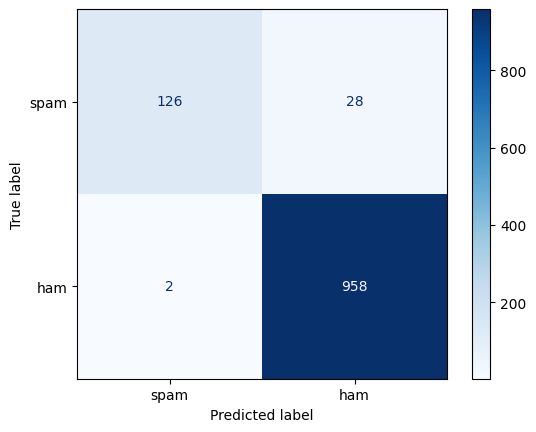

Sensitivity: 0.82
Specificity: 1.00
Model accuracy: 97.31 %


In [36]:
#Create char model here.
char_gram_length_min = 1 # If set to zero, we only train word-grams
char_gram_length_max = 3 # If set to zero, we only train word-grams

fasttext_char_model = fasttext.train_supervised(
    input='./data/train_data.txt',
    verbose=True,
    minn=char_gram_length_min,
    maxn=char_gram_length_max
)
accuracy_char_model, cm_char_model, sens_char_model, spec_char_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_char_model, verbose=True)

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

Finally, below is a small test of different `maxn` and `minn` parameters. Where we examine the accuracy of each model with the given parameters, to find the (seemingly) optimal values.

</span>

In [37]:
start = 1
stop = 8
results = []

for i in tqdm(range(start, stop)):
    temp_results = []
    for j in tqdm(range(start, stop)):

        fasttext_char_model = fasttext.train_supervised(
            input='./data/train_data.txt',
            verbose=True,
            minn=i,
            maxn=j,
        )
        accuracy_char_model, cm_char_model, sens_char_model, spec_char_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_char_model, verbose=False)
        temp_results.append(accuracy_char_model)
    results.append(temp_results)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256173 lr:  0.000000 avg.loss:  0.118941 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  255996 lr:  0.000000 avg.loss:  0.157428 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256614 lr:  0.000000 avg.loss:  0.192774 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128361 lr:  0.000000 avg.loss:  0.220231 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128685 lr:  0.000000 avg.loss:  0.239597 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128095 lr:  0.000000 avg.loss:  0.265824 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256836 lr:  0.000000 avg.loss:  0.127945 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257419 lr:  0.000000 avg.loss:  0.158625 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257028 lr:  0.000000 avg.loss:  0.214986 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256764 lr:  0.000000 avg.loss:  0.262751 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128817 lr:  0.000000 avg.loss:  0.278179 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128320 lr:  0.000000 avg.loss:  0.294181 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  255789 lr:  0.000000 avg.loss:  0.130411 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256413 lr:  0.000000 avg.loss:  0.137166 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257156 lr:  0.000000 avg.loss:  0.194649 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256692 lr:  0.000000 avg.loss:  0.252111 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257228 lr:  0.000000 avg.loss:  0.289033 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  128436 lr:  0.000000 avg.loss:  0.324409 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257149 lr:  0.000000 avg.loss:  0.135912 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257177 lr:  0.000000 avg.loss:  0.114444 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257371 lr:  0.000000 avg.loss:  0.130011 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256525 lr:  0.000000 avg.loss:  0.192974 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257329 lr:  0.000000 avg.loss:  0.254778 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256640 lr:  0.000000 avg.loss:  0.289562 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257022 lr:  0.000000 avg.loss:  0.118237 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256957 lr:  0.000000 avg.loss:  0.120716 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256757 lr:  0.000000 avg.loss:  0.133736 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256689 lr:  0.000000 avg.loss:  0.123389 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257140 lr:  0.000000 avg.loss:  0.189671 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257289 lr:  0.000000 avg.loss:  0.231962 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256270 lr:  0.000000 avg.loss:  0.124553 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256766 lr:  0.000000 avg.loss:  0.130262 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256885 lr:  0.000000 avg.loss:  0.137645 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256535 lr:  0.000000 avg.loss:  0.128593 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256692 lr:  0.000000 avg.loss:  0.136336 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256427 lr:  0.000000 avg.loss:  0.173918 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

  0%|          | 0/7 [00:00<?, ?it/s]

Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256824 lr:  0.000000 avg.loss:  0.125985 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256528 lr:  0.000000 avg.loss:  0.131941 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256565 lr:  0.000000 avg.loss:  0.134614 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257123 lr:  0.000000 avg.loss:  0.131156 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  257269 lr:  0.000000 avg.loss:  0.129575 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  256695 lr:  0.000000 avg.loss:  0.139094 ETA:   0h 0m 0s
Read 0M words
Number of words:  13551
Number of labels: 2
Progress: 100.0% words/sec/thread:  

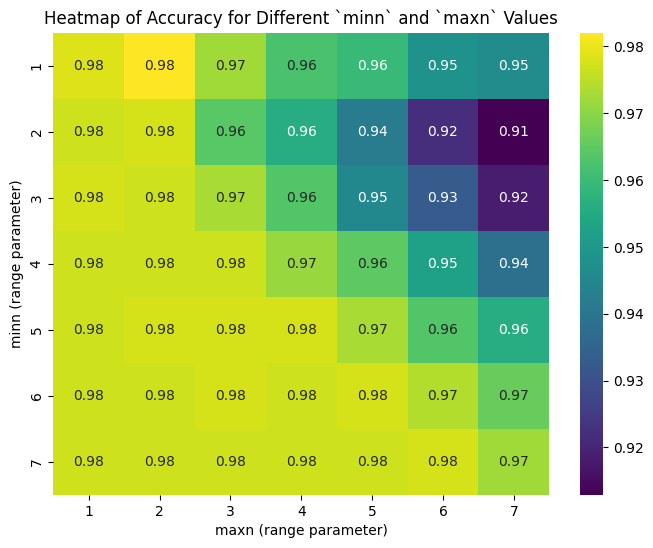

In [38]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap="viridis", xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.xlabel("maxn (range parameter)")
plt.ylabel("minn (range parameter)")
plt.title("Heatmap of Accuracy for Different `minn` and `maxn` Values")
plt.show()